# CAP 6619 - Deep Learning
## Project 4
## Image classification using the CIFAR-10 dataset
## Jennifer R. Gogova & Peter J. Worth

Inspired by:

https://www.kaggle.com/c/cifar-10

https://keras.io/examples/vision/metric_learning/

https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer


### Setup

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

import random

import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Ensuring reproducibility of results
np.random.seed(42)

### Part 1: Load dataset

In [ ]:
#
# note that we add the validatiuonb data set here so we can 
# compare apples to apples for all of our models
#
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

# Normalize the image data
x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)

x_val = x_val.astype("float32") / 255.0
y_val = np.squeeze(y_val)

x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)

170508288/170498071 [==============================] - 14s 0us/step


### Part 2: Explore dataset

In [ ]:
# Number of samples
print("Number of training samples: ",y_train.shape[0])
print("Number of validation samples: ",y_val.shape[0])
print("Number of test samples: ", y_test.shape[0])

Number of training samples:  35000
Number of validation samples:  15000
Number of test samples:  10000


In [ ]:
# Number of classes
num_classes = max(y_test)+1
print(num_classes)

10


In [ ]:
# Shape of image data
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(35000, 32, 32, 3)
(15000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
# Shape of y data
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(35000,)
(15000,)
(10000,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


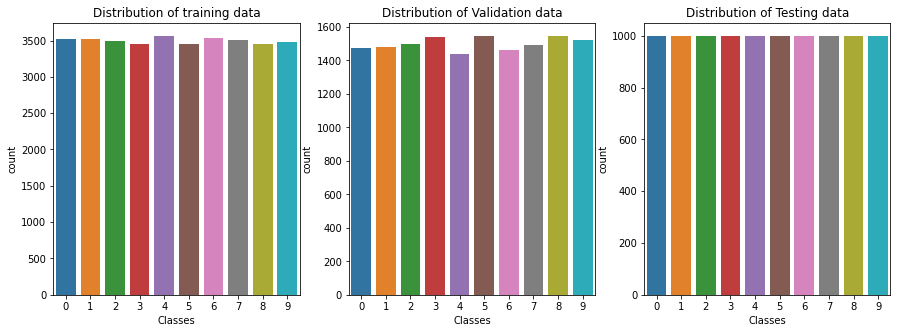

In [ ]:
# Distribution of classes in training samples

fig, axs = plt.subplots(1,3,figsize=(15,5)) 

# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')

# Count plot for validation set
sns.countplot(y_val.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Validation data')
axs[1].set_xlabel('Classes')

# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[2])
axs[2].set_title('Distribution of Testing data')
axs[2].set_xlabel('Classes')

plt.show()

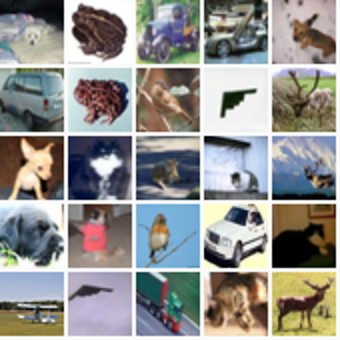

In [ ]:
#
# Show collage of 25 (randomly selected) images
# from training data
#
height_width = 32

def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage

#
# Show a collage of 5x5 random images
# max number set by sample size
#
sample_idxs = np.random.randint(0, 35000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

In [ ]:
idx = y_train[0]
print(idx)

7


In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [ ]:
labels[idx]

'Horse'

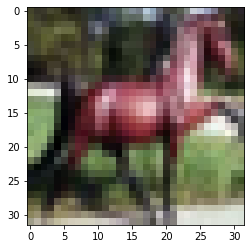

In [ ]:
plt.imshow(x_train[0])

In [ ]:
# 
# Convert class vectors to binary class matrices. 
# This is called one-hot encoding.
#
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Shape of y data
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(35000, 10)
(15000, 10)
(10000, 10)


In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

### Part 3: Build your 1st model

In this case we will start by using a convolutional neural network (CNN) built from scratch. 


In [ ]:
batch_size = 128
epochs = 70
data_augmentation = False

In [ ]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTEN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#model.summary()

In [ ]:
# Initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### Part 4: Train your first model

In [ ]:
#
# fit model to validation data set
#
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True)

Epoch 1/70
274/274 [==============================] - 16s 16ms/step - loss: 2.0827 - accuracy: 0.2313 - val_loss: 1.8909 - val_accuracy: 0.3169
Epoch 2/70
274/274 [==============================] - 4s 14ms/step - loss: 1.8045 - accuracy: 0.3462 - val_loss: 1.7051 - val_accuracy: 0.3862
Epoch 3/70
274/274 [==============================] - 4s 14ms/step - loss: 1.6757 - accuracy: 0.3917 - val_loss: 1.5626 - val_accuracy: 0.4379
Epoch 4/70
274/274 [==============================] - 4s 14ms/step - loss: 1.5964 - accuracy: 0.4211 - val_loss: 1.5039 - val_accuracy: 0.4547
Epoch 5/70
274/274 [==============================] - 4s 14ms/step - loss: 1.5350 - accuracy: 0.4437 - val_loss: 1.4561 - val_accuracy: 0.4747
Epoch 6/70
274/274 [==============================] - 4s 14ms/step - loss: 1.4848 - accuracy: 0.4647 - val_loss: 1.4157 - val_accuracy: 0.4939
Epoch 7/70
274/274 [==============================] - 4s 14ms/step - loss: 1.4441 - accuracy: 0.4802 - val_loss: 1.3582 - val_accuracy: 0.518

In [ ]:
import matplotlib.pyplot as plt

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


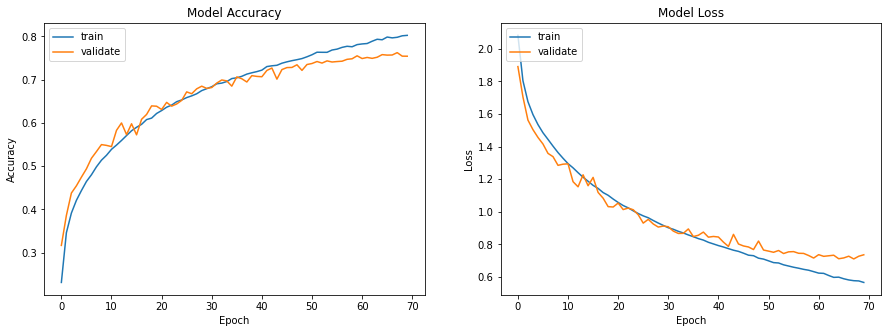

In [ ]:
plotmodelhistory(history)

### Part 5: Evaluate your 1st model

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.7499 - accuracy: 0.7472
Test loss: 0.7499345541000366
Test accuracy: 0.7472000122070312


In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

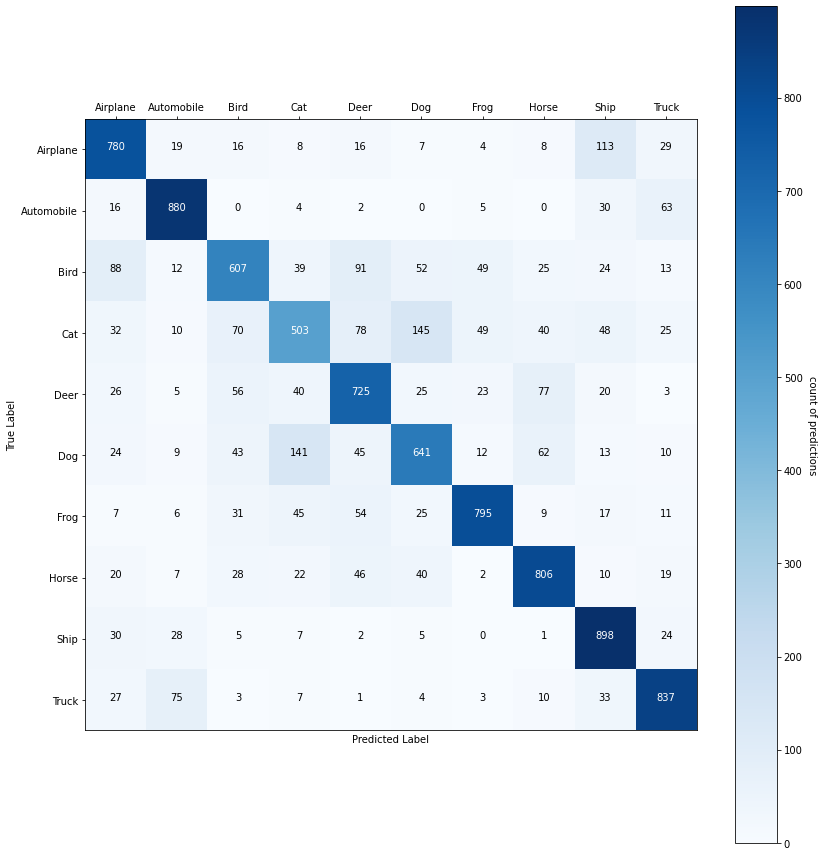

In [ ]:
# Plot confusion matrix

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [ ]:
labels

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1000
           1       0.84      0.88      0.86      1000
           2       0.71      0.61      0.65      1000
           3       0.62      0.50      0.55      1000
           4       0.68      0.72      0.70      1000
           5       0.68      0.64      0.66      1000
           6       0.84      0.80      0.82      1000
           7       0.78      0.81      0.79      1000
           8       0.74      0.90      0.81      1000
           9       0.81      0.84      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.74      0.75      0.74     10000
weighted avg       0.74      0.75      0.74     10000



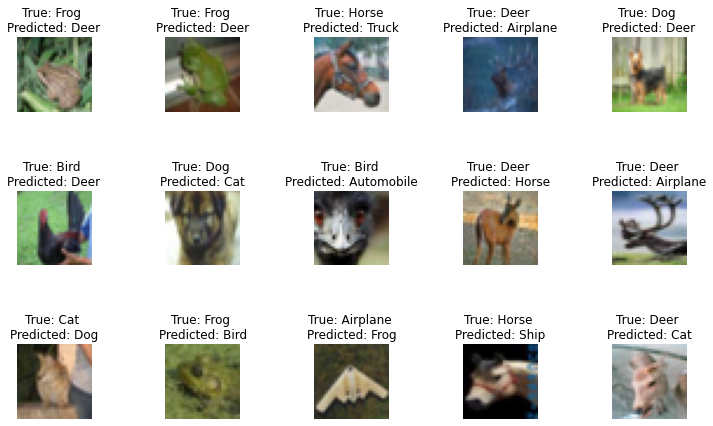

In [ ]:
# Inspect errors
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [ ]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    predict_x=model.predict(test_image) 
    test_result=np.argmax(predict_x,axis=1)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

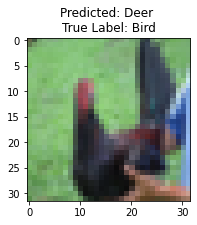

In [ ]:
show_test(25)

### Part 6: Transfer Learning

#### Transfer Learning: setup

In [ ]:
from keras import Sequential
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical

from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#Import dataset (again)
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [ ]:
# Print the dimensions of the datasets to make sure everything's kosher

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [ ]:
# One hot encode the labels. Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [ ]:
# Lets print the dimensions one more time to see if things changed the way we expected

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


#### Attempt #1: ResNet50 as a base model 

#####Sources

(Dwivedi 2019) *Understanding and Coding a ResNet in Keras*, by Priya Dwivedi, Jan 2019. Available at https://colab.research.google.com/drive/1ZcaZZu3LUdZR4qRYzh-90VN6kUQ7v0aD?usp=sharing#scrollTo=2RrjI9sPy8dR

ResNet50 on Kaggle:

https://www.kaggle.com/datasets/keras/resnet50

Upscale examples:
- https://www.kaggle.com/code/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner/notebook

- https://medium.com/@andrew.dabydeen/transfer-learning-using-resnet50-and-cifar-10-6242ed4b4245

On Loss Functions for Image Processing: 

https://towardsdatascience.com/choosing-and-customizing-loss-functions-for-image-processing-a0e4bf665b0a

#####What is a ResNet Network?

From Dwivedi 2019:

*ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer vision tasks. This model was the winner of ImageNet challenge in 2015. The fundamental breakthrough with ResNet was it allowed us to train extremely deep neural networks with 150+layers successfully. Prior to ResNet training very deep neural networks was difficult due to the problem of vanishing gradients.*

*AlexNet, the winner of ImageNet 2012 and the model that apparently kick started the focus on deep learning had only 8 convolutional layers, the VGG network had 19 and Inception or GoogleNet had 22 layers and ResNet 152 had 152 layers.*

...

*However, increasing network depth does not work by simply stacking layers together. Deep networks are hard to train because of the notorious vanishing gradient problem — as the gradient is back-propagated to earlier layers, repeated multiplication may make the gradient extremely small. As a result, as the network goes deeper, its performance gets saturated or even starts degrading rapidly.*


##### Build the Model

In [ ]:
batch_size= 512
epochs=40
learn_rate=.003

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate)

In [ ]:
base_model_1 = ResNet50(include_top=False,
                        weights='imagenet',
                        input_shape=(32,32,3),
                        classes=y_train.shape[1])

model_1=Sequential()        # create the model

#Add the ResNet50 layer and then a Flatten layer 
model_1.add(base_model_1)
model_1.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(4000,activation=('relu'),input_dim=512))
model_1.add(Dense(2000,activation=('relu'))) 
model_1.add(Dense(1000,activation=('relu'))) 
model_1.add(Dense(500,activation=('relu')))

model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
#
# callback function which stops at fixed accuracy rate
#
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.996):
      print("\nReached 99.6% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
# Compile the model
model_1.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

##### Train the Model

In [ ]:
#CALLBACKS = []
#CALLBACKS.append(myCallback())

# Train the model
history_1 = model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose = 1,
              validation_data=(x_val, y_val),
              #callbacks=CALLBACKS,
              shuffle=True)

Epoch 1/40
69/69 [==============================] - 27s 256ms/step - loss: 1.8358 - accuracy: 0.3494 - val_loss: 2.0320 - val_accuracy: 0.3405
Epoch 2/40
69/69 [==============================] - 15s 215ms/step - loss: 1.0049 - accuracy: 0.6487 - val_loss: 1.1207 - val_accuracy: 0.6239
Epoch 3/40
69/69 [==============================] - 14s 198ms/step - loss: 0.6326 - accuracy: 0.7799 - val_loss: 0.9430 - val_accuracy: 0.6747
Epoch 4/40
69/69 [==============================] - 14s 199ms/step - loss: 0.3924 - accuracy: 0.8683 - val_loss: 0.8926 - val_accuracy: 0.6996
Epoch 5/40
69/69 [==============================] - 15s 218ms/step - loss: 0.2217 - accuracy: 0.9318 - val_loss: 0.9493 - val_accuracy: 0.7037
Epoch 6/40
69/69 [==============================] - 14s 201ms/step - loss: 0.1177 - accuracy: 0.9676 - val_loss: 1.0455 - val_accuracy: 0.7025
Epoch 7/40
69/69 [==============================] - 14s 201ms/step - loss: 0.0692 - accuracy: 0.9825 - val_loss: 1.1766 - val_accuracy: 0.7059

#####Analyze the Model

In [ ]:
# list all data in history
print(history_1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
import matplotlib.pyplot as plt

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

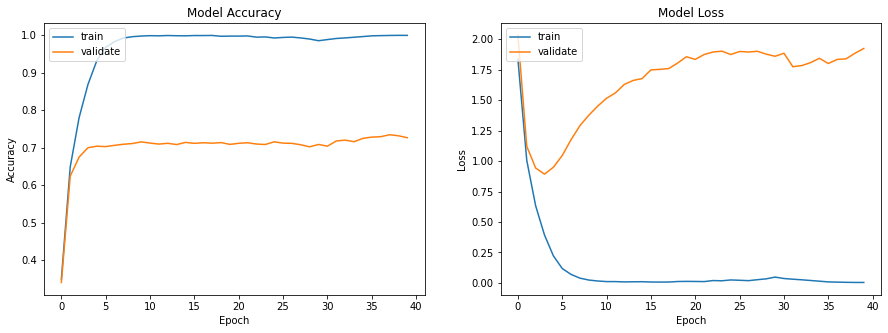

In [ ]:
plotmodelhistory(history_1)

In [ ]:
# Score trained model.
scores = model_1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model_1.predict(x_test)

313/313 [==============================] - 5s 15ms/step - loss: 1.9043 - accuracy: 0.7317
Test loss: 1.9043195247650146
Test accuracy: 0.7317000031471252


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [ ]:
y_pred=np.argmax(pred,axis=1)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

Confusion matrix, without normalization


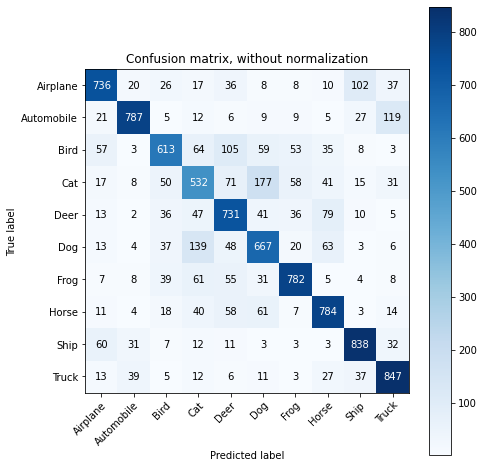

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


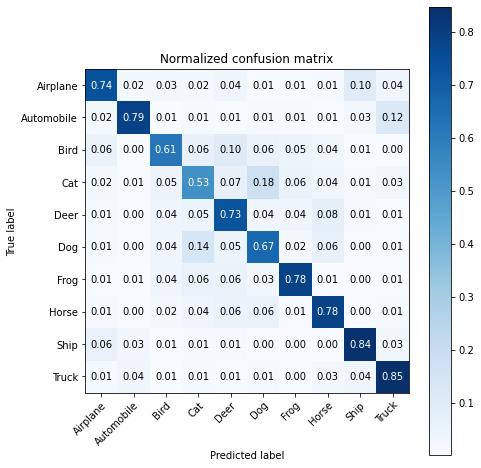

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')
# plt.show()

In [ ]:
labels

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1000
           1       0.87      0.79      0.83      1000
           2       0.73      0.61      0.67      1000
           3       0.57      0.53      0.55      1000
           4       0.65      0.73      0.69      1000
           5       0.63      0.67      0.65      1000
           6       0.80      0.78      0.79      1000
           7       0.75      0.78      0.76      1000
           8       0.80      0.84      0.82      1000
           9       0.77      0.85      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



#### Attempt #2: ResNet50 as base model

**ResNet50 modifications**

The code below uses the same base model and simply changes optimizer and other hyperparameters.

- *Variation #1 - changed the optimizer (adam)*

- *Variation #2 - added a dropout layer (0.5)*

- *Variation #3 - changed the learn_rate(0.01)*

#####2A: ResNet50 Variation #1 - Change Optimizer (adam)

In [ ]:
batch_size= 512
epochs=40
learn_rate=.003

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate)

In [ ]:
base_model_2 = ResNet50(include_top=False,
                        weights='imagenet',
                        input_shape=(32,32,3),
                        classes=y_train.shape[1])

model_3=Sequential()

# add the base model and a flatten layer
model_3.add(base_model_2)
model_3.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_3.add(Dense(4000,activation=('relu'),input_dim=512))
model_3.add(Dense(2000,activation=('relu'))) 
model_3.add(Dense(1000,activation=('relu'))) 
model_3.add(Dense(500,activation=('relu')))
model_3.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [ ]:
# Changing the optimizer (adam)
# Compile the model
model_3.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Train the model
history_3 = model_3.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose = 1,
              validation_data=(x_val, y_val),
              shuffle=True)

Epoch 1/40
69/69 [==============================] - 20s 218ms/step - loss: 3.1182 - accuracy: 0.1565 - val_loss: 429.2332 - val_accuracy: 0.1008
Epoch 2/40
69/69 [==============================] - 14s 207ms/step - loss: 1.4965 - accuracy: 0.4293 - val_loss: 7.1923 - val_accuracy: 0.1008
Epoch 3/40
69/69 [==============================] - 14s 210ms/step - loss: 1.0303 - accuracy: 0.6405 - val_loss: 6.6200 - val_accuracy: 0.1018
Epoch 4/40
69/69 [==============================] - 14s 206ms/step - loss: 0.8050 - accuracy: 0.7273 - val_loss: 4.8822 - val_accuracy: 0.0996
Epoch 5/40
69/69 [==============================] - 14s 205ms/step - loss: 0.6754 - accuracy: 0.7755 - val_loss: 4.4163 - val_accuracy: 0.1039
Epoch 6/40
69/69 [==============================] - 14s 204ms/step - loss: 0.5705 - accuracy: 0.8111 - val_loss: 3.5877 - val_accuracy: 0.0995
Epoch 7/40
69/69 [==============================] - 14s 206ms/step - loss: 0.4939 - accuracy: 0.8352 - val_loss: 3.3266 - val_accuracy: 0.12

In [ ]:
# list all data in history
print(history_3.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


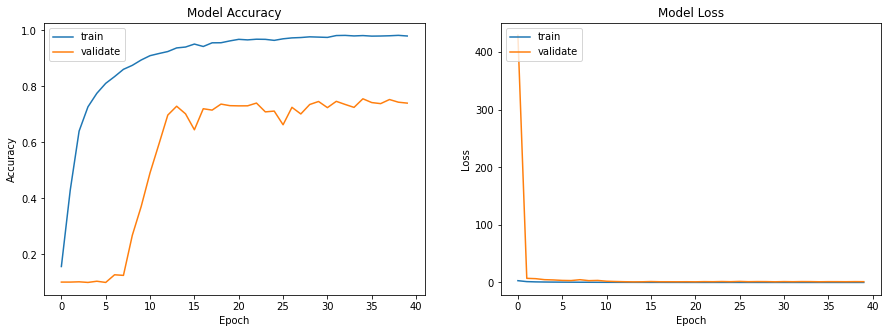

In [ ]:
plotmodelhistory(history_3)

In [ ]:
# Score trained model.
scores = model_3.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model_3.predict(x_test)

313/313 [==============================] - 5s 15ms/step - loss: 1.3941 - accuracy: 0.7419
Test loss: 1.3941010236740112
Test accuracy: 0.7419000267982483


Confusion matrix, without normalization


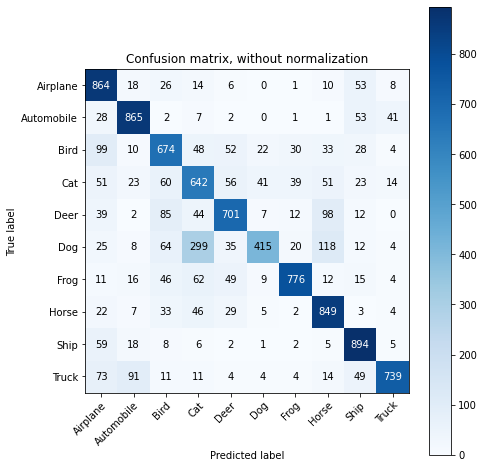

In [ ]:
# Computing and plotting non-normalizaed confusion matrix 
y_pred=np.argmax(pred,axis=1)
y_true=np.argmax(y_test,axis=1)

confusion_mtx=confusion_matrix(y_true,y_pred)

plot_confusion_matrix(y_true, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


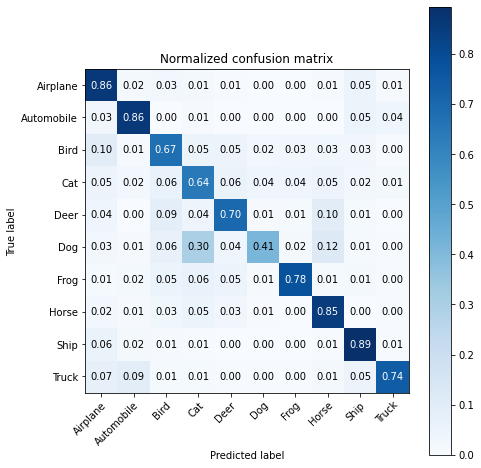

In [ ]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
labels

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76      1000
           1       0.82      0.86      0.84      1000
           2       0.67      0.67      0.67      1000
           3       0.54      0.64      0.59      1000
           4       0.75      0.70      0.72      1000
           5       0.82      0.41      0.55      1000
           6       0.87      0.78      0.82      1000
           7       0.71      0.85      0.77      1000
           8       0.78      0.89      0.83      1000
           9       0.90      0.74      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.76      0.74      0.74     10000
weighted avg       0.76      0.74      0.74     10000



#####**2A.1 ResNet50 with Image Upscaling**

Code primarily sourced from 

(Dabydeen 2019) *Transfer Learning Using ResNet50 and CIFAR-10* by Andrew Dabydeen (May 2019) available at https://medium.com/@andrew.dabydeen/transfer-learning-using-resnet50-and-cifar-10-6242ed4b4245 with code at GitHub here: https://github.com/frlim/data2040_final/blob/master/project_2/CNN_Final.ipynb 

Scaling factor numbers from https://www.kaggle.com/code/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner/notebook

######Load and Transform Data Set

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print("labels: ", labels)

labels:  ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


In [ ]:
from keras.utils import np_utils
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(35000, 32, 32, 3)
(15000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(35000, 32, 32, 3)
(15000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
y_train = np_utils.to_categorical(y_train, 10)
y_val = np_utils.to_categorical(y_val, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(35000, 10)
(15000, 10)
(10000, 10)


######Build Model

In [ ]:
from tensorflow.keras.applications import ResNet50

#conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#conv_base.summary()

In [ ]:
import tensorflow.keras as K

ressie4 = K.models.Sequential()

# upscale / upsample
#ressie4.add(K.layers.UpSampling2D((2,2)))
#ressie4.add(K.layers.UpSampling2D((2,2)))
ressie4.add(K.layers.UpSampling2D((7,7)))

# add base model
ressie4.add(conv_base)

ressie4.add(K.layers.Flatten())
ressie4.add(K.layers.BatchNormalization())
ressie4.add(K.layers.Dense(128, activation='relu'))
ressie4.add(K.layers.Dropout(0.5))
ressie4.add(K.layers.BatchNormalization())
ressie4.add(K.layers.Dense(64, activation='relu'))
ressie4.add(K.layers.Dropout(0.5))
ressie4.add(K.layers.BatchNormalization())
ressie4.add(K.layers.Dense(10, activation='softmax'))

In [ ]:
ressie4.compile(optimizer=K.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


######Train Model

In [ ]:
#ressie_hist = ressie4.fit(x_train, y_train, epochs=5, batch_size=20, validation_data=(x_val, y_val))

#
# note changing the batch_size blows up the fit for some reason, staying at 20
#
ressie_hist = ressie4.fit(x_train, y_train, epochs=5, batch_size=20, validation_data=(x_val, y_val))

Epoch 1/5
1750/1750 [==============================] - 455s 253ms/step - loss: 0.7436 - acc: 0.3513 - val_loss: 0.5478 - val_acc: 0.7446
Epoch 2/5
1750/1750 [==============================] - 443s 253ms/step - loss: 0.6277 - acc: 0.5749 - val_loss: 0.4604 - val_acc: 0.8248
Epoch 3/5
1750/1750 [==============================] - 443s 253ms/step - loss: 0.5425 - acc: 0.6867 - val_loss: 0.3837 - val_acc: 0.8717
Epoch 4/5
1750/1750 [==============================] - 444s 253ms/step - loss: 0.4577 - acc: 0.7574 - val_loss: 0.3153 - val_acc: 0.8963
Epoch 5/5
1750/1750 [==============================] - 477s 273ms/step - loss: 0.3721 - acc: 0.8079 - val_loss: 0.2390 - val_acc: 0.9167


######Evaluate Model

In [ ]:
ressie_scores = ressie4.evaluate(x_test, y_test, verbose=2)

313/313 - 29s - loss: 0.2396 - acc: 0.9136 - 29s/epoch - 93ms/step


In [ ]:
print('Test loss:', ressie_scores[0])
print('Test accuracy:', ressie_scores[1])

Test loss: 0.23956742882728577
Test accuracy: 0.9136000275611877


In [ ]:
# list all data in history
print(ressie_hist.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [ ]:
import matplotlib.pyplot as plt

def plotressiemodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    
    # summarize history for accuracy
    axs[0].plot(history.history['acc']) 
    axs[0].plot(history.history['val_acc']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')

    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

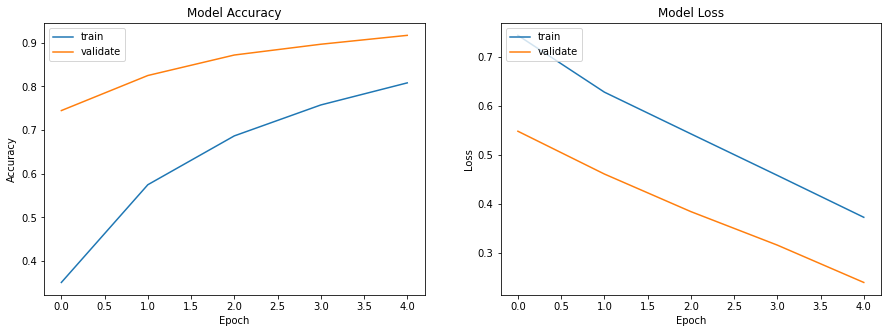

In [ ]:
plotressiemodelhistory(ressie_hist)

In [ ]:
# make prediction.
pred = ressie4.predict(x_test)

Confusion matrix, without normalization


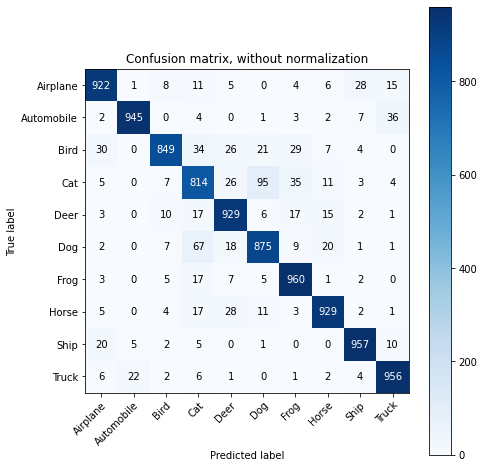

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Computing and plotting non-normalizaed confusion matrix 
y_pred=np.argmax(pred,axis=1)
y_true=np.argmax(y_test,axis=1)

confusion_mtx=confusion_matrix(y_true,y_pred)

plot_confusion_matrix(y_true, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


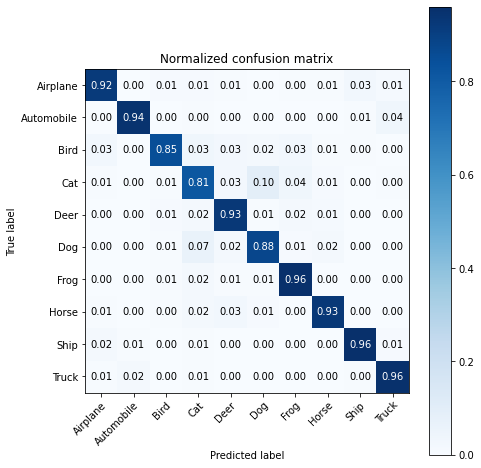

In [ ]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
labels

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1000
           1       0.97      0.94      0.96      1000
           2       0.95      0.85      0.90      1000
           3       0.82      0.81      0.82      1000
           4       0.89      0.93      0.91      1000
           5       0.86      0.88      0.87      1000
           6       0.90      0.96      0.93      1000
           7       0.94      0.93      0.93      1000
           8       0.95      0.96      0.95      1000
           9       0.93      0.96      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



#####2B: ResNet Variation #2 - Add DropOut Layer (0.5)

In [ ]:
batch_size= 512       # batch size change, see if affects training performance
epochs=40
learn_rate=.003

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate)

In [ ]:
# Adding a Dropout Layer to the base model
base_model_3 = ResNet50(include_top=False,
                        weights='imagenet',
                        input_shape=(32,32,3),
                        classes=y_train.shape[1])

model_4=Sequential()

#Add the ResNet base model and a flatten layer 
model_4.add(base_model_3)
model_4.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_4.add(Dense(4000,activation=('relu'),input_dim=512))
model_4.add(Dense(2000,activation=('relu'))) 
model_4.add(Dense(1000,activation=('relu'))) 
model_4.add(Dense(500,activation=('relu')))

model_4.add(Dropout(0.5)) # adding Dropout 

model_4.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [ ]:
# Compile the model
model_4.compile(optimizer=sgd,                    # change back to sgd
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Train the model
history_4 = model_4.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose = 1,
              validation_data=(x_val, y_val),
              shuffle=True)

Epoch 1/40
69/69 [==============================] - 19s 208ms/step - loss: 2.0439 - accuracy: 0.2752 - val_loss: 3.4014 - val_accuracy: 0.0923
Epoch 2/40
69/69 [==============================] - 15s 212ms/step - loss: 1.2120 - accuracy: 0.5752 - val_loss: 7.2851 - val_accuracy: 0.0991
Epoch 3/40
69/69 [==============================] - 15s 213ms/step - loss: 0.8335 - accuracy: 0.7088 - val_loss: 5.7320 - val_accuracy: 0.0991
Epoch 4/40
69/69 [==============================] - 14s 197ms/step - loss: 0.5914 - accuracy: 0.7962 - val_loss: 7.9218 - val_accuracy: 0.0991
Epoch 5/40
69/69 [==============================] - 14s 198ms/step - loss: 0.4097 - accuracy: 0.8615 - val_loss: 10.0622 - val_accuracy: 0.1119
Epoch 6/40
69/69 [==============================] - 14s 200ms/step - loss: 0.2726 - accuracy: 0.9081 - val_loss: 8.7117 - val_accuracy: 0.0991
Epoch 7/40
69/69 [==============================] - 14s 200ms/step - loss: 0.1808 - accuracy: 0.9405 - val_loss: 5.2403 - val_accuracy: 0.123

In [ ]:
# list all data in history
print(history_4.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


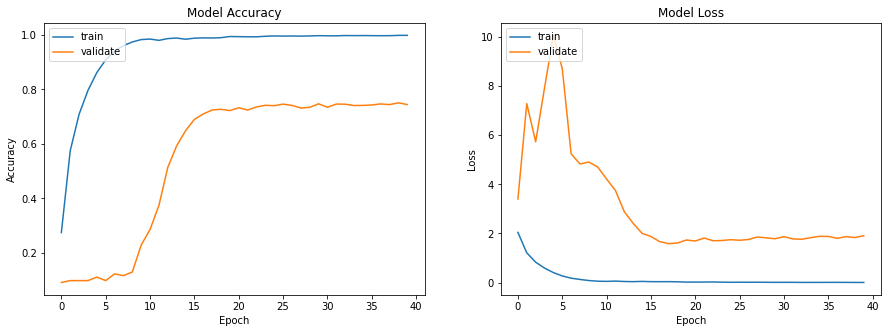

In [ ]:
plotmodelhistory(history_4)

In [ ]:
# Score trained model.
scores = model_4.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model_4.predict(x_test)

313/313 [==============================] - 6s 20ms/step - loss: 1.9631 - accuracy: 0.7437
Test loss: 1.9630730152130127
Test accuracy: 0.7437000274658203


Confusion matrix, without normalization


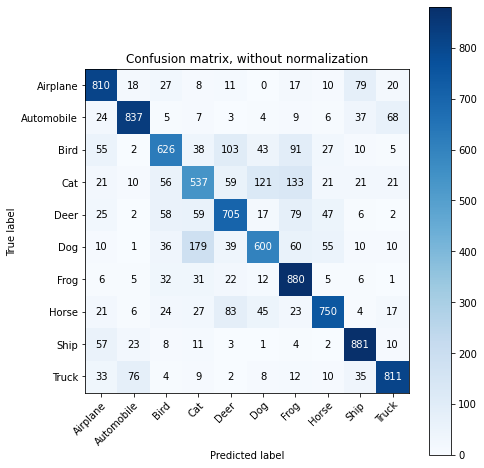

In [ ]:
# Computing and plotting non-normalizaed confusion matrix 
y_pred=np.argmax(pred,axis=1)
y_true=np.argmax(y_test,axis=1)

confusion_mtx=confusion_matrix(y_true,y_pred)

plot_confusion_matrix(y_true, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


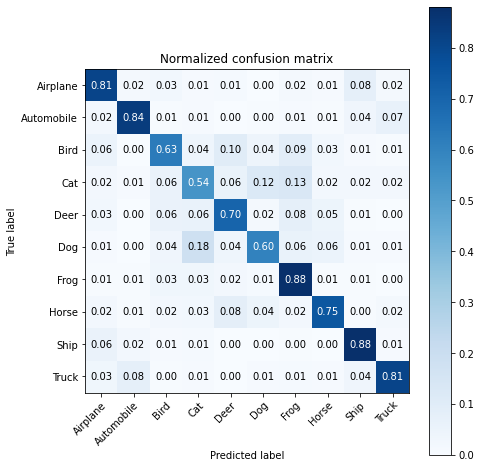

In [ ]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
labels

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1000
           1       0.85      0.84      0.85      1000
           2       0.71      0.63      0.67      1000
           3       0.59      0.54      0.56      1000
           4       0.68      0.70      0.69      1000
           5       0.71      0.60      0.65      1000
           6       0.67      0.88      0.76      1000
           7       0.80      0.75      0.78      1000
           8       0.81      0.88      0.84      1000
           9       0.84      0.81      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



#####2C: ResNet50 Variation #3 - Change learning rate (.01)

In [ ]:
batch_size= 512       # same as last run
epochs=40
learn_rate=.01        # learning rate change

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate)

In [ ]:
base_model_4 = ResNet50(include_top=False,
                        weights='imagenet',
                        input_shape=(32,32,3),
                        classes=y_train.shape[1])

model_5=Sequential()

#Add the ResNet50 layer and then a Flattening layer
model_5.add(base_model_4)
model_5.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_5.add(Dense(4000,activation=('relu'),input_dim=512))
model_5.add(Dense(2000,activation=('relu'))) 
model_5.add(Dense(1000,activation=('relu'))) 
model_5.add(Dense(500,activation=('relu')))

model_5.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [ ]:
# Compile the model
model_5.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Train the model
history_5 = model_5.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose = 1,
              validation_data=(x_val, y_val),
              shuffle=True)

Epoch 1/40
69/69 [==============================] - 19s 211ms/step - loss: 1.4229 - accuracy: 0.4988 - val_loss: 2.3957 - val_accuracy: 0.0989
Epoch 2/40
69/69 [==============================] - 14s 198ms/step - loss: 0.7044 - accuracy: 0.7555 - val_loss: 2.5390 - val_accuracy: 0.1005
Epoch 3/40
69/69 [==============================] - 15s 215ms/step - loss: 0.4114 - accuracy: 0.8579 - val_loss: 2.6409 - val_accuracy: 0.1027
Epoch 4/40
69/69 [==============================] - 14s 199ms/step - loss: 0.2457 - accuracy: 0.9171 - val_loss: 2.7556 - val_accuracy: 0.1084
Epoch 5/40
69/69 [==============================] - 14s 200ms/step - loss: 0.1536 - accuracy: 0.9481 - val_loss: 3.2694 - val_accuracy: 0.1109
Epoch 6/40
69/69 [==============================] - 14s 202ms/step - loss: 0.1170 - accuracy: 0.9597 - val_loss: 5.0120 - val_accuracy: 0.1053
Epoch 7/40
69/69 [==============================] - 14s 202ms/step - loss: 0.1099 - accuracy: 0.9625 - val_loss: 3.9404 - val_accuracy: 0.1162

In [ ]:
# list all data in history
print(history_5.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


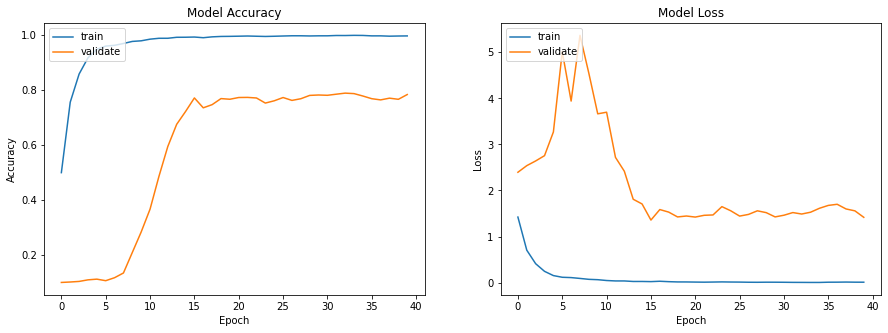

In [ ]:
plotmodelhistory(history_5)

In [ ]:
# Score trained model.
scores = model_5.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model_5.predict(x_test)

313/313 [==============================] - 5s 14ms/step - loss: 1.4318 - accuracy: 0.7861
Test loss: 1.431805968284607
Test accuracy: 0.7860999703407288


Confusion matrix, without normalization


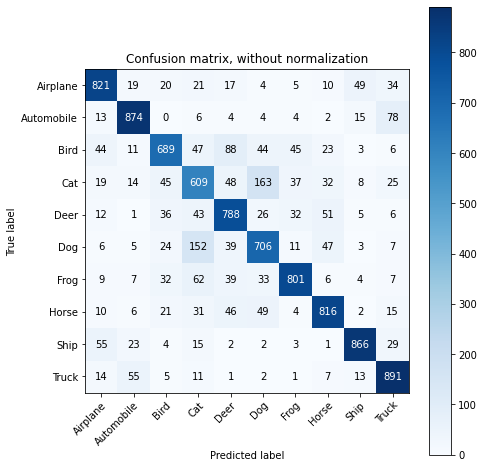

In [ ]:
# Computing and plotting non-normalizaed confusion matrix 
y_pred=np.argmax(pred,axis=1)
y_true=np.argmax(y_test,axis=1)

confusion_mtx=confusion_matrix(y_true,y_pred)

plot_confusion_matrix(y_true, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


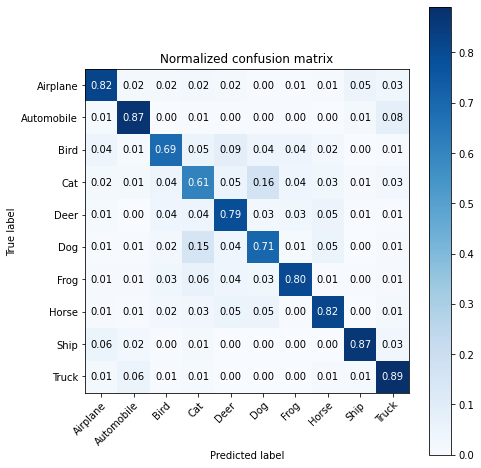

In [ ]:
# Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
labels

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.86      0.87      0.87      1000
           2       0.79      0.69      0.73      1000
           3       0.61      0.61      0.61      1000
           4       0.74      0.79      0.76      1000
           5       0.68      0.71      0.69      1000
           6       0.85      0.80      0.82      1000
           7       0.82      0.82      0.82      1000
           8       0.89      0.87      0.88      1000
           9       0.81      0.89      0.85      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



#### Attempt #3: DenseNet121 as a base model

[Model construction code (+ transformations) originally sourced from Montoya 2020. Analysis, charting and data validation code taken from previous assignments.]

##### Sources



(Montoya 2020) *Hands-on the CIFAR 10 Dataset With Transfer Learning* by Thomas Montoya, Sep 2020. Available here https://medium.com/swlh/hands-on-the-cifar-10-dataset-with-transfer-learning-2e768fd6c318 (code here: https://gist.github.com/thomasmontoya123/e0237534cbb3d39d092ce67a3f7c273d#file-cifar10_transfer-ipynb). 

(Sarkar 2020) *Creating DenseNet121 with TensorFlow* by Arjun Sarkar, Jul 2020. Available (behind paywall) at https://medium.com/p/edbc08a956d8.

(Huang, Liu, van der Maaten & Weinberger 2018) *Densely Connected Convolutional Networks* by Huang, Liu, van der Maaten and Weinberger 2018. Available at https://arxiv.org/abs/1608.06993


Other sources and references:

https://medium.com/swlh/hands-on-the-cifar-10-dataset-with-transfer-learning-2e768fd6c318
https://gist.github.com/thomasmontoya123/e0237534cbb3d39d092ce67a3f7c273d#file-cifar10_transfer-ipynb
https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet121
https://www.kaggle.com/code/phmagic/keras-densenet121-multi-label-baseline/notebook
https://keras.io/api/applications/densenet/
https://towardsdatascience.com/creating-densenet-121-with-tensorflow-edbc08a956d8

##### DenseNet Architectural Overview


(Quote and images from Sarkar 2020)

*DenseNet (Dense Convolutional Network) is an architecture that focuses on making the deep learning networks go even deeper, but at the same time making them more efficient to train, by using shorter connections between the layers. DenseNet is a convolutional neural network where each layer is connected to all other layers that are deeper in the network, that is, the first layer is connected to the 2nd, 3rd, 4th and so on, the second layer is connected to the 3rd, 4th, 5th and so on.*


![picture](https://drive.google.com/uc?export=view&id=17IG5WJP3c2SGeRnRw_q3OWmYv8S5OECU)


*This is done to enable maximum information flow between the layers of the network. To preserve the feed-forward nature, each layer obtains inputs from all the previous layers and passes on its own feature maps to all the layers which will come after it. Unlike Resnets it does not combine features through summation but combines the features by concatenating them. So the ‘ith’ layer has ‘i’ inputs and consists of feature maps of all its preceding convolutional blocks. Its own feature maps are passed on to all the next ‘I-i’ layers.* 

*This introduces ‘(I(I+1))/2’ connections in the network, rather than just ‘I’ connections as in traditional deep learning architectures. It hence requires fewer parameters than traditional convolutional neural networks, as there is no need to learn unimportant feature maps.*

*DenseNet consists of two important blocks other than the basic convolutional and pooling layers. they are the Dense Blocks and the Transition layers.*

#####Load and Transform Data

In [ ]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow import keras as K

# load cifar 10
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = K.datasets.cifar10.load_data()

x_train_orig, x_val_orig, y_train_orig, y_val_orig=train_test_split(x_train_orig,y_train_orig,test_size=.3)

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print("labels: ", labels)

labels:  ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


In [ ]:
print()
print("---x and y train, val and test data shape BEFORE preprocessing---")
print()
print("x_train (original) shape: ", x_train_orig.shape)
print("y_train (original) shape: ", y_train_orig.shape)
print()
print("x_val (original) shape: ", x_val_orig.shape)
print("y_val (original) shape: ", y_val_orig.shape)
print()
print("x_test (original) shape:", x_test_orig.shape)
print("y_test (original) shape: ", y_test_orig.shape)


---x and y train, val and test data shape BEFORE preprocessing---

x_train (original) shape:  (35000, 32, 32, 3)
y_train (original) shape:  (35000, 1)

x_val (original) shape:  (15000, 32, 32, 3)
y_val (original) shape:  (15000, 1)

x_test (original) shape: (10000, 32, 32, 3)
y_test (original) shape:  (10000, 1)


In [ ]:
#
# pre-procces data
#

import tensorflow as tf 
import tensorflow.keras as K

"""
Pre-processes the data for the model
  :param X: numpy.ndarray of shape (m, 32, 32, 3)
    containing the CIFAR 10 data, where m is the
    number of data points
  :param Y: numpy.ndarray of shape (m,) containing
    the CIFAR 10 labels for X
  :returns: X_p, Y_p
"""

def preprocess_data(X, Y):
  X_p = K.applications.densenet.preprocess_input(X)     # densenet preprocessing
  Y_p = K.utils.to_categorical(Y, 10)                   # one-hot
  return X_p, Y_p


x_train, y_train = preprocess_data(x_train_orig, y_train_orig)
x_val, y_val = preprocess_data(x_val_orig, y_val_orig)
x_test, y_test = preprocess_data(x_test_orig, y_test_orig)

In [ ]:
print("---x and y train and test data shape AFTER preprocessing---")
print()
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print()
print("x_val shape: ", x_val.shape)
print("y_val shape: ", y_val.shape)
print()
print("x_test shape:", x_test.shape)
print("y_test shape: ", y_test.shape)

---x and y train and test data shape AFTER preprocessing---

x_train shape:  (35000, 32, 32, 3)
y_train shape:  (35000, 10)

x_val shape:  (15000, 32, 32, 3)
y_val shape:  (15000, 10)

x_test shape: (10000, 32, 32, 3)
y_test shape:  (10000, 10)


#####Build the (Transfer Learning) Model

NB: we have to 'upscale' the image to normalize against imagenet data. This is because:

*almost all the base (Transfer Learing) models 
in keras were trained on the ImageNet data set, which is a different size 
than the CIFAR-10 data set (32,32, 3) so we need to pre-process our data 
to feed the model. There are a few methods to normalize the data and since we will use a base model, we need to normalize our data in the same way it was 
normalized in the first place by the people who created the base model.*



In [ ]:
batch_size= 512
epochs=40
learn_rate=.003

In [ ]:
# input tensor
inputs = K.Input(shape=(32, 32, 3))

In [ ]:
#
# upscale layer
#
# we need to resize the image so we do this by adding a 'lambda layer'
# which allows for a custom transformation routine to be inserted into
# a neural network. 
# See https://keras.io/api/layers/core_layers/lambda/ for 
# more detailed information
#
# here we see a lambda function defined inline that
# converts the image to 160 x 160
#
upscale = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [160, 160],method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [ ]:
# load base model
#
# note lambda layer inserted as a tensor, 
# output from above
#
base_model_dn121 = K.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3),
                                        pooling='max')

29097984/29084464 [==============================] - 1s 0us/step


In [ ]:
# no training of base layers
for layer in base_model_dn121.layers:
  layer.trainable = False

In [ ]:
CALLBACKS = []
MODEL_PATH = 'cifar10.h5'

#optimizer = K.optimizers.Adam()
optimizer = K.optimizers.SGD()

# add top layers
out = base_model_dn121.output

out = K.layers.Flatten()(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(256, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(128, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.BatchNormalization()(out)
out = K.layers.Dense(64, activation='relu')(out)
out = K.layers.Dropout(0.3)(out)
out = K.layers.Dense(10, activation='softmax')(out)

# callbacks
"""
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))
"""

CALLBACKS.append(myCallback())

In [ ]:
# model compile
model_dense = K.models.Model(inputs=inputs, outputs=out)

model_dense.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model_dense.summary()

#####Train the Model

In [ ]:
# train

history_dense = model_dense.fit(x=x_train,
                      y=y_train,
                      batch_size=batch_size,
                      epochs=epochs,
#                      callbacks=CALLBACKS,
                      validation_data=(x_val, y_val))

Epoch 1/40
69/69 [==============================] - 94s 1s/step - loss: 2.5077 - accuracy: 0.1775 - val_loss: 1.9055 - val_accuracy: 0.3035
Epoch 2/40
69/69 [==============================] - 73s 1s/step - loss: 1.8190 - accuracy: 0.3697 - val_loss: 1.3307 - val_accuracy: 0.6539
Epoch 3/40
69/69 [==============================] - 74s 1s/step - loss: 1.4700 - accuracy: 0.4999 - val_loss: 1.0347 - val_accuracy: 0.7445
Epoch 4/40
69/69 [==============================] - 75s 1s/step - loss: 1.2593 - accuracy: 0.5748 - val_loss: 0.8605 - val_accuracy: 0.7774
Epoch 5/40
69/69 [==============================] - 75s 1s/step - loss: 1.0972 - accuracy: 0.6356 - val_loss: 0.7502 - val_accuracy: 0.7951
Epoch 6/40
69/69 [==============================] - 75s 1s/step - loss: 0.9979 - accuracy: 0.6697 - val_loss: 0.6739 - val_accuracy: 0.8088
Epoch 7/40
69/69 [==============================] - 75s 1s/step - loss: 0.9212 - accuracy: 0.6966 - val_loss: 0.6194 - val_accuracy: 0.8177
Epoch 8/40
69/69 [==

#####Evaluate the Model

In [ ]:
model_dense.evaluate(x_val, y_val, batch_size=128, verbose=1)

118/118 [==============================] - 26s 196ms/step - loss: 0.3734 - accuracy: 0.8749


[0.37341204285621643, 0.8749333620071411]

In [ ]:
# list all data in history
print(history_dense.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


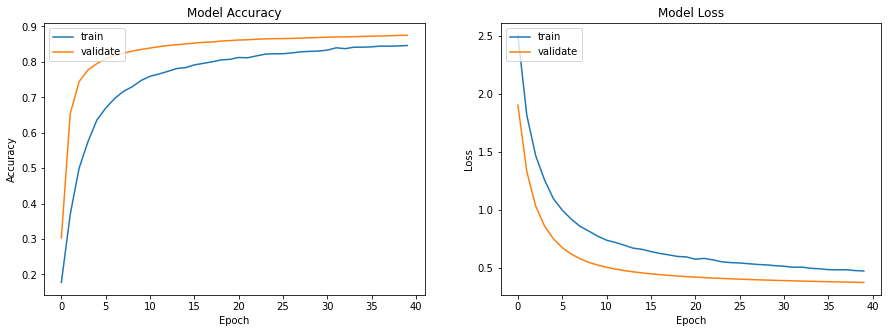

In [ ]:
plotmodelhistory(history_dense)

In [ ]:
#
# Score trained model on test data
#
scores = model_dense.evaluate(x_test, y_test, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 20s 59ms/step - loss: 0.3753 - accuracy: 0.8742
Test loss: 0.3753260672092438
Test accuracy: 0.8741999864578247


In [ ]:
#
# make predictions on test data
#
pred = model_dense.predict(x_test)

In [ ]:
# 
# we explore the structure of the predictions nparray
# note again due to sigmoid output that the values are
# float probabilities that need to be converted later
# for comparison purposes (true vs expected)
#
for x in range (0, 5):

  print("predictions[", x, "]: ", pred[x])

  for y in range (0, 10):
    print("rounded values: ", round(pred[x][y], 2))

predictions[ 0 ]:  [0.   0.01 0.01 0.84 0.01 0.08 0.03 0.01 0.01 0.  ]
rounded values:  0.0
rounded values:  0.01
rounded values:  0.01
rounded values:  0.84
rounded values:  0.01
rounded values:  0.08
rounded values:  0.03
rounded values:  0.01
rounded values:  0.01
rounded values:  0.0
predictions[ 1 ]:  [1.53e-03 3.19e-02 1.15e-04 3.08e-05 3.64e-06 2.27e-06 2.71e-05 7.27e-06
 9.65e-01 1.52e-03]
rounded values:  0.0
rounded values:  0.03
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.96
rounded values:  0.0
predictions[ 2 ]:  [4.48e-03 1.09e-01 1.18e-03 7.72e-05 4.38e-05 1.28e-05 1.01e-04 1.86e-05
 8.83e-01 1.77e-03]
rounded values:  0.0
rounded values:  0.11
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.88
rounded values:  0.0
predictions[ 3 ]:  [0.66 0.02 0.06 0.08 0.02 0.02 0.02 0.06 0.0

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

#
# we get the max argument of each element in the 
# arrays to capture the single true, or predicted, value
#
y_pred=np.argmax(pred,axis=1)     # predicted values
y_true=np.argmax(y_test,axis=1)   # true values

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

Confusion matrix, without normalization


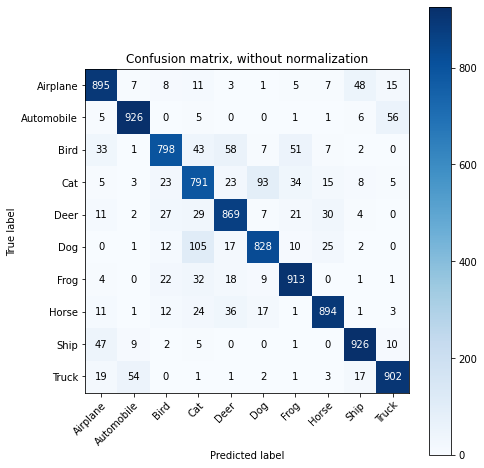

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


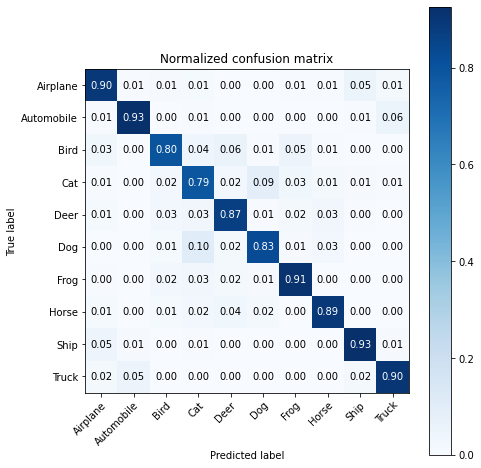

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1000
           1       0.92      0.93      0.92      1000
           2       0.88      0.80      0.84      1000
           3       0.76      0.79      0.77      1000
           4       0.85      0.87      0.86      1000
           5       0.86      0.83      0.84      1000
           6       0.88      0.91      0.90      1000
           7       0.91      0.89      0.90      1000
           8       0.91      0.93      0.92      1000
           9       0.91      0.90      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
#
# define shared variables as we analyze the predictions of the test 
# data set
#
yhat = pred

Y_true = np.argmax(y_test, axis=1)
Y_pred_classes = np.argmax(yhat, axis=1)

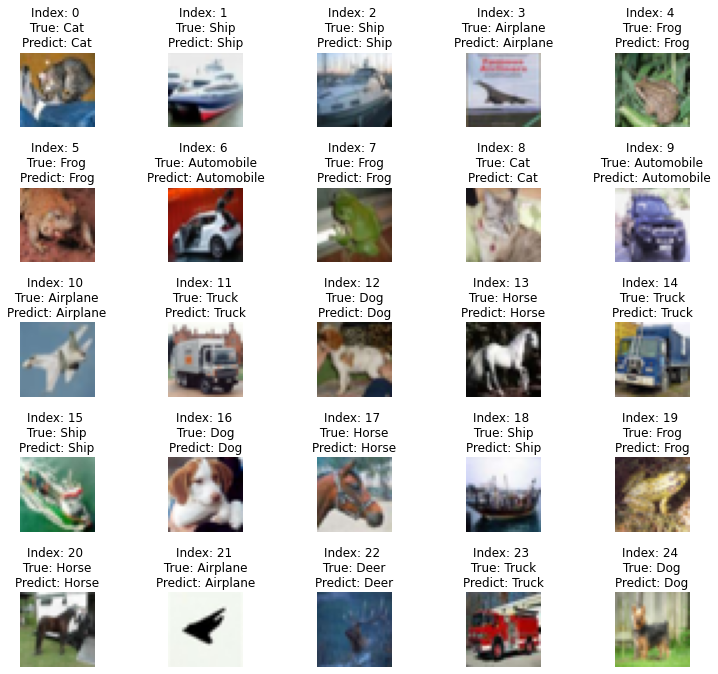

In [ ]:
#############################
# True Predictions
#

R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

right_classified_idx = np.where(Y_pred_classes == Y_true)[0]

for i in np.arange(0, R*C):
    axes[i].imshow(x_test_orig[right_classified_idx[i]])
    axes[i].set_title("Index: %s \n True: %s \nPredict: %s" % (right_classified_idx[i], labels[Y_true[right_classified_idx[i]]], labels[Y_pred_classes[right_classified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

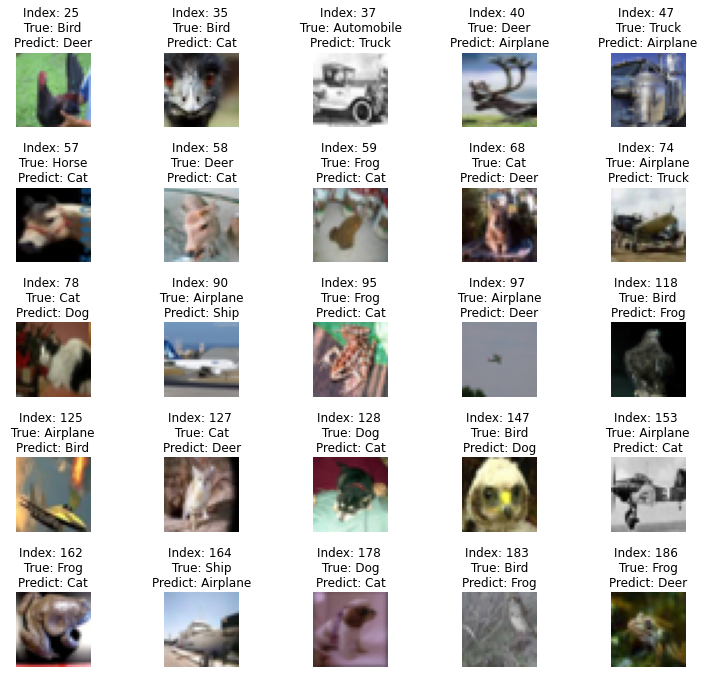

In [ ]:
##################################
#Incorrect (False) Predictions
#
R = 5
C = 5

fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]

axes[i].imshow(x_test_orig[misclassified_idx[i]])

for i in np.arange(0, R*C):
    axes[i].imshow(x_test_orig[misclassified_idx[i]])
    axes[i].set_title("Index: %s \n True: %s \nPredict: %s" % (misclassified_idx[i], labels[Y_true[misclassified_idx[i]]], labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [ ]:
#
# we double check the confusion matrix numbers here
# by tallying up the manual calcualtions of correct or incorrect (false)
# predictions as well as the count of false positives and false negatives
# for each of the categories of image (classifcation labels)
#

print("# correct predictions: ", right_classified_idx.size)

print("# incorrect predictions: ", misclassified_idx.size)

# correct predictions:  8742
# incorrect predictions:  1258


In [ ]:
#
# from Assignment 3, Face Display code
# modified to support these images in this format
#
def img_display(show_imgs, show_labels, numbers, show_name = True):

    fig, ax = plt.subplots(1, numbers, figsize=(numbers, 1.5), squeeze = False)

    for i, axes in enumerate(ax.flat):
        axes.imshow(show_imgs[i], cmap = 'bone')
        axes.set(xticks=[], yticks=[])
        
        if show_name:
            axes.set_xlabel(labels[show_labels[i]].split()[-1][:10])
    
    plt.show()


-----------------------------------------------------
.           ------Airplane metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  895 ]


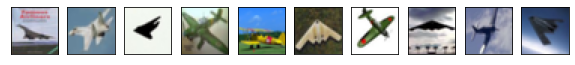


False Negatives:
[imgs to show:  10 ; total imgs found:  105 ]


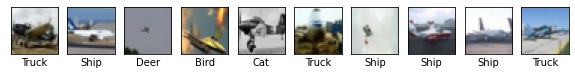


False Positives:
[imgs to show:  10 ; total imgs found:  135 ]


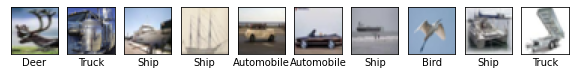

-----------------------------------------------------
.           ------Automobile metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  926 ]


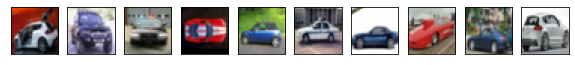


False Negatives:
[imgs to show:  10 ; total imgs found:  74 ]


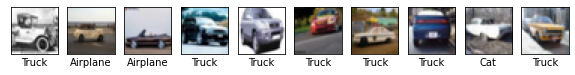


False Positives:
[imgs to show:  10 ; total imgs found:  78 ]


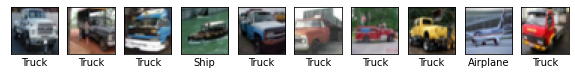

-----------------------------------------------------
.           ------Bird metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  798 ]


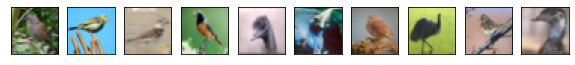


False Negatives:
[imgs to show:  10 ; total imgs found:  202 ]


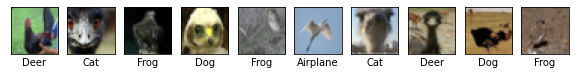


False Positives:
[imgs to show:  10 ; total imgs found:  106 ]


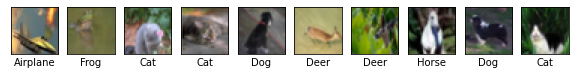

-----------------------------------------------------
.           ------Cat metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  791 ]


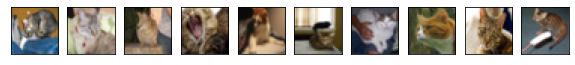


False Negatives:
[imgs to show:  10 ; total imgs found:  209 ]


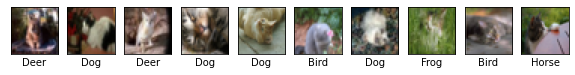


False Positives:
[imgs to show:  10 ; total imgs found:  255 ]


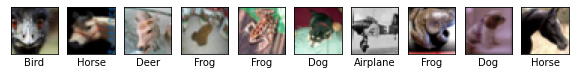

-----------------------------------------------------
.           ------Deer metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  869 ]


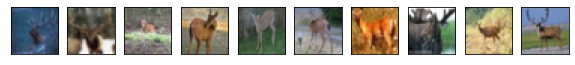


False Negatives:
[imgs to show:  10 ; total imgs found:  131 ]


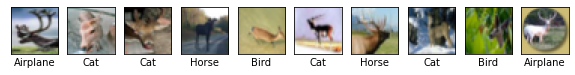


False Positives:
[imgs to show:  10 ; total imgs found:  156 ]


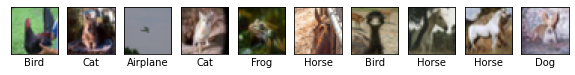

-----------------------------------------------------
.           ------Dog metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  828 ]


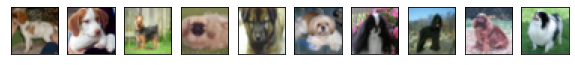


False Negatives:
[imgs to show:  10 ; total imgs found:  172 ]


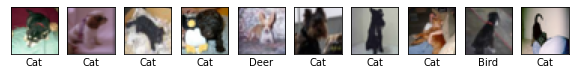


False Positives:
[imgs to show:  10 ; total imgs found:  136 ]


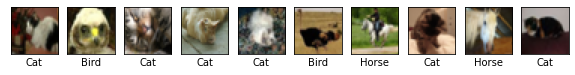

-----------------------------------------------------
.           ------Frog metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  913 ]


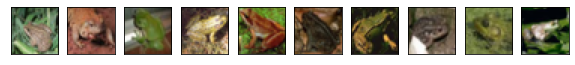


False Negatives:
[imgs to show:  10 ; total imgs found:  87 ]


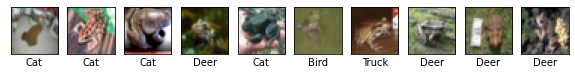


False Positives:
[imgs to show:  10 ; total imgs found:  125 ]


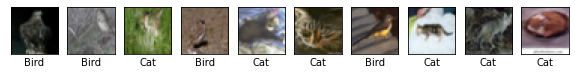

-----------------------------------------------------
.           ------Horse metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  894 ]


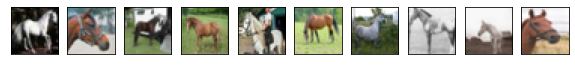


False Negatives:
[imgs to show:  10 ; total imgs found:  106 ]


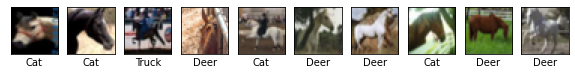


False Positives:
[imgs to show:  10 ; total imgs found:  88 ]


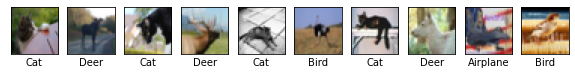

-----------------------------------------------------
.           ------Ship metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  926 ]


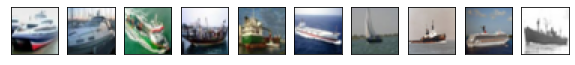


False Negatives:
[imgs to show:  10 ; total imgs found:  74 ]


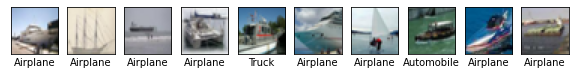


False Positives:
[imgs to show:  10 ; total imgs found:  89 ]


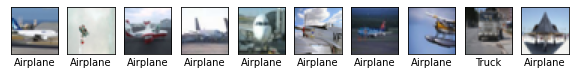

-----------------------------------------------------
.           ------Truck metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  902 ]


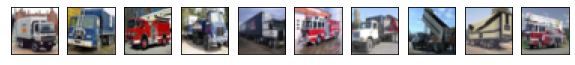


False Negatives:
[imgs to show:  10 ; total imgs found:  98 ]


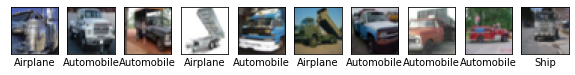


False Positives:
[imgs to show:  10 ; total imgs found:  90 ]


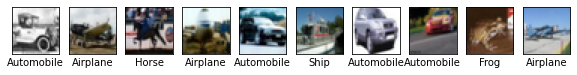

-----------------------------------------------------


In [ ]:
#
# prints out Correct Predictions, False Negative Predictions, and 
# False Positive Predictions for each name in faces.target_names
# NB that it prints out max of 10 values for each category for image
#

print()
print('-----------------------------------------------------')

for i, label in enumerate(labels):                        # one loop for each label

  print('.           ------' + label + ' metrics------')
  print()
  print('Correct Predictions:')          
  mask = (Y_true == i) & (Y_pred_classes == i)
  correct = sum(mask)                                     # total corrects
  numbers = min(10, sum(mask))
  print("[imgs to show: ", numbers, "; total imgs found: ", correct, "]")
  img_display(x_test_orig[mask], Y_pred_classes[mask], numbers, show_name = False)

  print()
  print('False Negatives:')                               # should have been positives
  mask = (Y_true == i) & (Y_pred_classes != i)
  false_negs = sum(mask)                                  # total false negatives
  numbers = min(10, sum(mask))
  print("[imgs to show: ", numbers, "; total imgs found: ", false_negs, "]")
  if numbers > 0:
    img_display(x_test_orig[mask], Y_pred_classes[mask], numbers)
  
  print()
  print('False Positives:')                               # should have been negatives
  mask = (Y_true != i) & (Y_pred_classes == i)
  false_poss = sum(mask)                                  # total false positives
  numbers = min(10, sum(mask))
  print("[imgs to show: ", numbers, "; total imgs found: ", false_poss, "]")
  if numbers > 0:
    img_display(x_test_orig[mask], y_true[mask], numbers)
      
  print('-----------------------------------------------------')

Attempt #5: using InceptionV3 as a base model

#### Attempt #4: InceptionV3 as base model

[Main branch of code sourced from Irla 2020]







#####Sources

(Irla 2020) *Transfer Learning using Inception-v3 for Image Classification* by Tejan Irla, Oct 2019 available at https://medium.com/analytics-vidhya/transfer-learning-using-inception-v3-for-image-classification-86700411251b with full code available at https://github.com/tejanirla/image_classification/blob/master/transfer_learning.ipynb.

(Szegedy, Vanhoucke, Ioffe, Shlens & Wojna 2015) *Rethinking the Inception Architecture for Computer Vision* by 
Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, Zbigniew Wojna, available at https://arxiv.org/abs/1512.00567.

https://www.kaggle.com/code/kmader/transfer-learning-with-inceptionv3/notebook

https://en.wikipedia.org/wiki/Inceptionv3

https://keras.io/api/applications/inceptionv3/

##### InceptionV3 Overview

Excerpt from Wikipedia contributors. "Inceptionv3." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 23 Sep. 2021. Web. 29 Jun. 2022.


*Inception v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge. The design of Inceptionv3 was intended to allow deeper networks while also keeping the number of parameters from growing too large: it has "under 25 million parameters", compared against 60 million for AlexNet.*

*Just as ImageNet can be thought of as a database of classified visual objects, Inception helps classification of objects in the world of computer vision. The Inceptionv3 architecture has been reused in many different applications, often used "pre-trained" from ImageNet. One such use is in life sciences, where it aids in the research of leukemia.*

*The original name (Inception) was codenamed this way after a popular "'we need to go deeper' internet meme" went viral, quoting a phrase from Inception film of Christopher Nolan.*

#####Data Load and Transform

In [ ]:
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow import keras as K

# load cifar 10
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = K.datasets.cifar10.load_data()

x_train_orig, x_val_orig, y_train_orig, y_val_orig=train_test_split(x_train_orig,y_train_orig,test_size=.3)

print()
print("---x and y train, val and test data shape BEFORE preprocessing---")
print()
print("x_train (original) shape: ", x_train_orig.shape)
print("y_train (original) shape: ", y_train_orig.shape)
print()
print("x_val (original) shape: ", x_val_orig.shape)
print("y_val (original) shape: ", y_val_orig.shape)
print()
print("x_test (original) shape:", x_test_orig.shape)
print("y_test (original) shape: ", y_test_orig.shape)


---x and y train, val and test data shape BEFORE preprocessing---

x_train (original) shape:  (35000, 32, 32, 3)
y_train (original) shape:  (35000, 1)

x_val (original) shape:  (15000, 32, 32, 3)
y_val (original) shape:  (15000, 1)

x_test (original) shape: (10000, 32, 32, 3)
y_test (original) shape:  (10000, 1)


In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print("labels: ", labels)

labels:  ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


In [ ]:
#
# pre-procces data
#
import tensorflow as tf 
import tensorflow.keras as K

"""
Pre-processes the data for the model
  :param X: numpy.ndarray of shape (m, 32, 32, 3)
    containing the CIFAR 10 data, where m is the
    number of data points
  :param Y: numpy.ndarray of shape (m,) containing
    the CIFAR 10 labels for X
  :returns: X_p, Y_p
"""
def preprocess_data(X, Y):
  X_p = K.applications.inception_v3.preprocess_input(X)   # scale pixels
  Y_p = K.utils.to_categorical(Y, 10)                     # one-hot
  return X_p, Y_p


x_train, y_train = preprocess_data(x_train_orig, y_train_orig)
x_val, y_val = preprocess_data(x_val_orig, y_val_orig)
x_test, y_test = preprocess_data(x_test_orig, y_test_orig)

In [ ]:
print("---x and y train and test data shape AFTER preprocessing---")
print()
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print()
print("x_val shape: ", x_val.shape)
print("y_val shape: ", y_val.shape)
print()
print("x_test shape:", x_test.shape)
print("y_test shape: ", y_test.shape)

---x and y train and test data shape AFTER preprocessing---

x_train shape:  (35000, 32, 32, 3)
y_train shape:  (35000, 10)

x_val shape:  (15000, 32, 32, 3)
y_val shape:  (15000, 10)

x_test shape: (10000, 32, 32, 3)
y_test shape:  (10000, 10)


#####Build the (Transfer Learning) Model

In [ ]:
batch_size= 512
epochs=40
learn_rate=.003

In [ ]:
#
# build upscale layer
#
# we need to resize the image so we do this by adding a 'lambda layer'
# which allows for a custom transformation routibne to be inserted into
# a neural network. 
# See https://keras.io/api/layers/core_layers/lambda/ for 
# more detailed information
#
# here we see a lambda function defined inline that
# converts the image to 160 x 160

inputs = K.Input(shape=(32, 32, 3))         # input tensor

upscale = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [160, 160],method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [ ]:
inputs.shape

TensorShape([None, 32, 32, 3])

In [ ]:
upscale.shape

TensorShape([None, 160, 160, 3])

In [ ]:
# load base model
#
# note lambda layer inserted as a tensor, 
# output from above
#

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape = (160, 160, 3),          # Shape of our images
    input_tensor=upscale,                 # scaled images from above
    include_top = False,                  # Leave out the last layer
    weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = K.layers.Flatten()(pre_trained_model.output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = K.layers.Dense(1024, activation='relu')(x)

x = K.layers.Dropout(0.2)(x)                        # Add a dropout rate of 0.2

x = K.layers.Dense(10, activation='softmax')(x)     # final softmax layer for classification

# from binary classification example (Dog/Cat)
#x = layers.Dense  (1, activation='sigmoid')(x)     

In [ ]:
#
# finish the model
#
model_incep = K.models.Model(pre_trained_model.input, x) 

# from DenseNet121 example
"""
model_incep.compile(optimizer = RMSprop(learning_rate=learn_rate), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
"""

model_incep.compile(optimizer = SGD(learning_rate=learn_rate), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

#model_incep.summary()

##### Training the Model

In [ ]:
callbacks = myCallback()

# train
history_incep = model_incep.fit(x=x_train,
                      y=y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=2,
#                      callbacks=[callbacks],
                      validation_data=(x_val, y_val))

Epoch 1/40
69/69 - 64s - loss: 1.1494 - accuracy: 0.6511 - val_loss: 0.6801 - val_accuracy: 0.7807 - 64s/epoch - 922ms/step
Epoch 2/40
69/69 - 45s - loss: 0.6814 - accuracy: 0.7787 - val_loss: 0.6272 - val_accuracy: 0.7953 - 45s/epoch - 658ms/step
Epoch 3/40
69/69 - 46s - loss: 0.5959 - accuracy: 0.8032 - val_loss: 0.5738 - val_accuracy: 0.8111 - 46s/epoch - 660ms/step
Epoch 4/40
69/69 - 45s - loss: 0.5392 - accuracy: 0.8191 - val_loss: 0.5581 - val_accuracy: 0.8162 - 45s/epoch - 658ms/step
Epoch 5/40
69/69 - 45s - loss: 0.5006 - accuracy: 0.8310 - val_loss: 0.5401 - val_accuracy: 0.8229 - 45s/epoch - 658ms/step
Epoch 6/40
69/69 - 45s - loss: 0.4689 - accuracy: 0.8435 - val_loss: 0.5303 - val_accuracy: 0.8243 - 45s/epoch - 659ms/step
Epoch 7/40
69/69 - 45s - loss: 0.4451 - accuracy: 0.8494 - val_loss: 0.5171 - val_accuracy: 0.8289 - 45s/epoch - 659ms/step
Epoch 8/40
69/69 - 52s - loss: 0.4211 - accuracy: 0.8576 - val_loss: 0.5147 - val_accuracy: 0.8279 - 52s/epoch - 760ms/step
Epoch 9/

##### Analyzing the Model

In [ ]:
model_incep.evaluate(x_val, y_val, batch_size=128, verbose=1)

118/118 [==============================] - 17s 128ms/step - loss: 0.4556 - accuracy: 0.8523


[0.45555463433265686, 0.8522666692733765]

In [ ]:
# list all data in history
print(history_incep.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


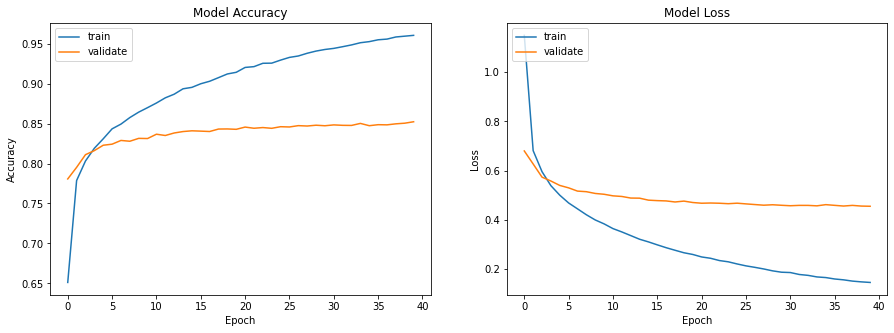

In [ ]:
plotmodelhistory(history_incep)

In [ ]:
#
# Score trained model on test data
#
scores = model_incep.evaluate(x_test, y_test, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 15s 46ms/step - loss: 0.4572 - accuracy: 0.8532
Test loss: 0.4571911096572876
Test accuracy: 0.8532000184059143


In [ ]:
#
# make predictions on test data
#
pred = model_incep.predict(x_test)

In [ ]:
# 
# we explore the structure of the predictions nparray
# note again due to sigmoid output that the values are
# float probabilities that need to be converted later
# for comparison purposed (true vs expected)
#
for x in range (0, 3):

  print("predictions[", x, "]: ", pred[x])

  for y in range (0, 10):
    print("rounded values: ", round(pred[x][y], 2))

predictions[ 0 ]:  [5.53e-08 6.35e-07 7.45e-06 9.72e-01 1.67e-05 2.50e-02 2.44e-03 6.56e-07
 1.79e-07 5.63e-07]
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.97
rounded values:  0.0
rounded values:  0.03
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
predictions[ 1 ]:  [3.62e-02 1.06e-02 1.17e-03 1.52e-05 8.21e-06 2.16e-05 4.78e-05 7.09e-06
 9.52e-01 1.36e-04]
rounded values:  0.04
rounded values:  0.01
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.95
rounded values:  0.0
predictions[ 2 ]:  [2.50e-05 3.54e-05 7.55e-07 1.25e-06 3.08e-07 2.21e-08 9.64e-08 1.76e-06
 1.00e+00 1.16e-05]
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  0.0
rounded values:  1.0
rounded values:  0.0


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

#
# we get the max argument of each element in the 
# arrays to capture the single true, or predicted, value
#
y_pred=np.argmax(pred,axis=1)     # predicted values
y_true=np.argmax(y_test,axis=1)   # true values

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

Confusion matrix, without normalization


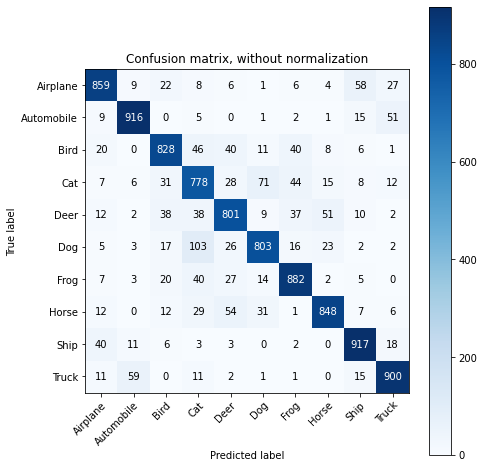

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


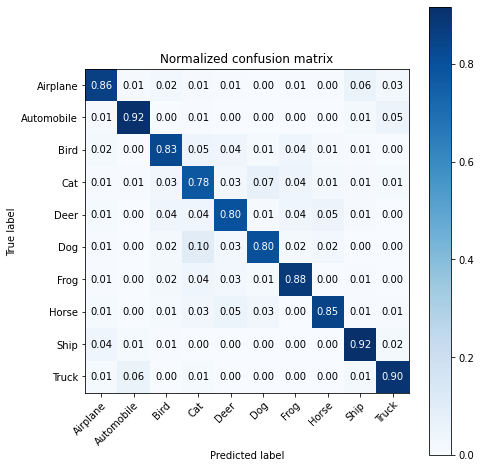

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1000
           1       0.91      0.92      0.91      1000
           2       0.85      0.83      0.84      1000
           3       0.73      0.78      0.75      1000
           4       0.81      0.80      0.81      1000
           5       0.85      0.80      0.83      1000
           6       0.86      0.88      0.87      1000
           7       0.89      0.85      0.87      1000
           8       0.88      0.92      0.90      1000
           9       0.88      0.90      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
#
# define shared variables as we analyze the predictions of the test 
# data set
#
yhat = pred

Y_true = np.argmax(y_test, axis=1)
Y_pred_classes = np.argmax(yhat, axis=1)

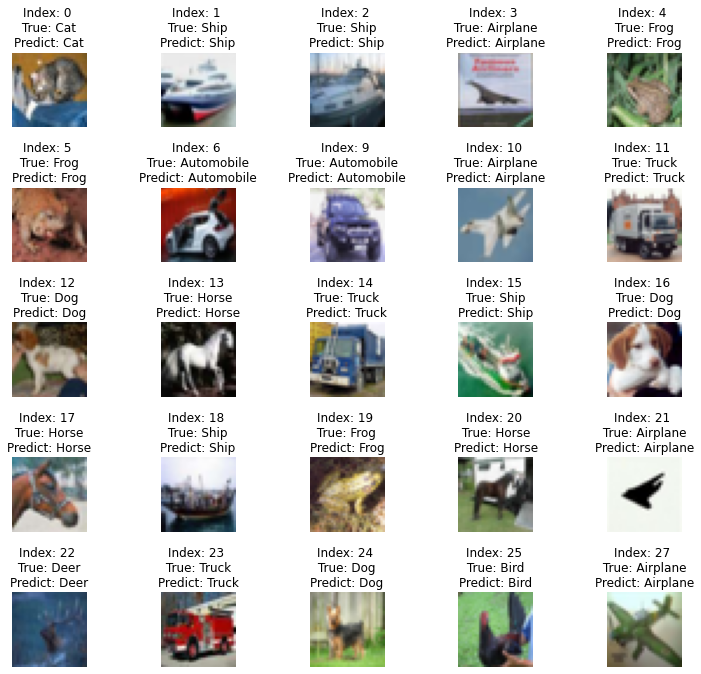

In [ ]:
#############################
# True Predictions
#

R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

right_classified_idx = np.where(Y_pred_classes == Y_true)[0]

for i in np.arange(0, R*C):
    axes[i].imshow(x_test_orig[right_classified_idx[i]])
    axes[i].set_title("Index: %s \n True: %s \nPredict: %s" % (right_classified_idx[i], labels[Y_true[right_classified_idx[i]]], labels[Y_pred_classes[right_classified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

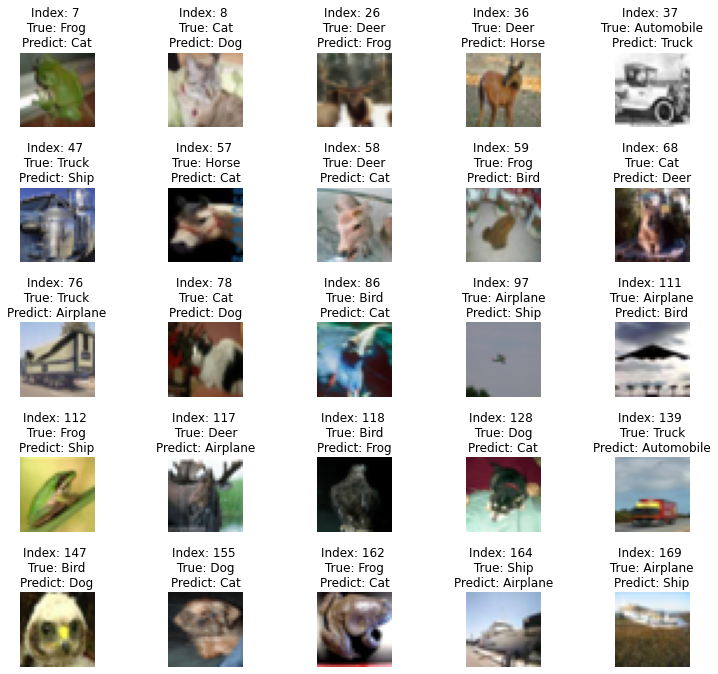

In [ ]:
##################################
#Incorrect (False) Predictions
#
R = 5
C = 5

fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]

axes[i].imshow(x_test_orig[misclassified_idx[i]])

for i in np.arange(0, R*C):
    axes[i].imshow(x_test_orig[misclassified_idx[i]])
    axes[i].set_title("Index: %s \n True: %s \nPredict: %s" % (misclassified_idx[i], labels[Y_true[misclassified_idx[i]]], labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [ ]:
#
# we double check the confusion matrix numbers here
# by tallying up the manual calcualtions of correct or incorrect (false)
# predictions as well as the count of false positives and false negatives
# for each of the categories of image (classifcation labels)
#

print("# correct predictions: ", right_classified_idx.size)

print("# incorrect predictions: ", misclassified_idx.size)

# correct predictions:  8532
# incorrect predictions:  1468


In [ ]:
#
# from Assignment 3, Face Display code
# modified to support these images in this format
#
def img_display(show_imgs, show_labels, numbers, show_name = True):

    fig, ax = plt.subplots(1, numbers, figsize=(numbers, 1.5), squeeze = False)

    for i, axes in enumerate(ax.flat):
        axes.imshow(show_imgs[i], cmap = 'bone')
        axes.set(xticks=[], yticks=[])
        
        if show_name:
            axes.set_xlabel(labels[show_labels[i]].split()[-1][:10])
    
    plt.show()


-----------------------------------------------------
.           ------Airplane metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  859 ]


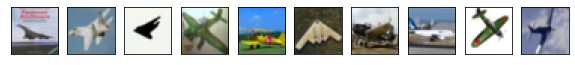


False Negatives:
[imgs to show:  10 ; total imgs found:  141 ]


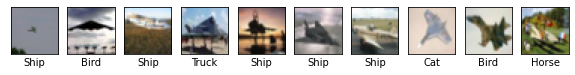


False Positives:
[imgs to show:  10 ; total imgs found:  123 ]


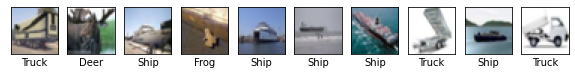

-----------------------------------------------------
.           ------Automobile metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  916 ]


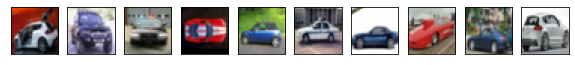


False Negatives:
[imgs to show:  10 ; total imgs found:  84 ]


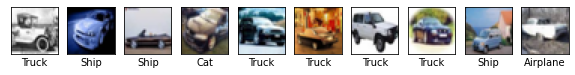


False Positives:
[imgs to show:  10 ; total imgs found:  93 ]


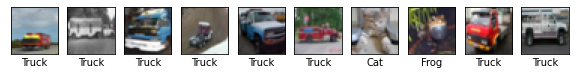

-----------------------------------------------------
.           ------Bird metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  828 ]


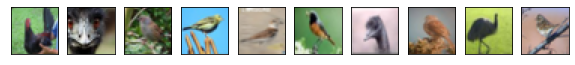


False Negatives:
[imgs to show:  10 ; total imgs found:  172 ]


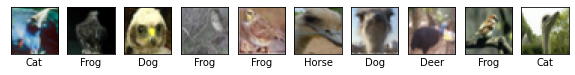


False Positives:
[imgs to show:  10 ; total imgs found:  146 ]


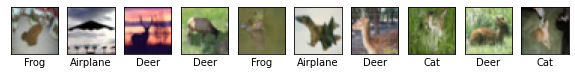

-----------------------------------------------------
.           ------Cat metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  778 ]


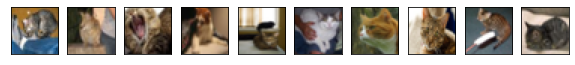


False Negatives:
[imgs to show:  10 ; total imgs found:  222 ]


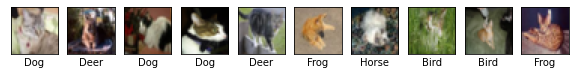


False Positives:
[imgs to show:  10 ; total imgs found:  283 ]


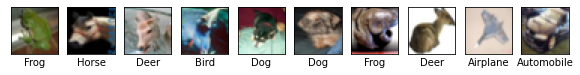

-----------------------------------------------------
.           ------Deer metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  801 ]


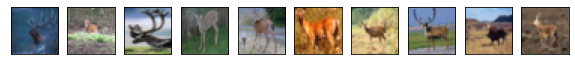


False Negatives:
[imgs to show:  10 ; total imgs found:  199 ]


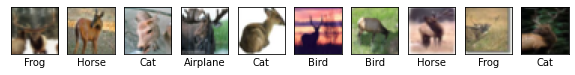


False Positives:
[imgs to show:  10 ; total imgs found:  186 ]


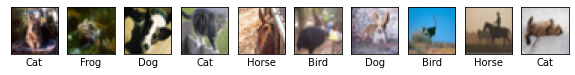

-----------------------------------------------------
.           ------Dog metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  803 ]


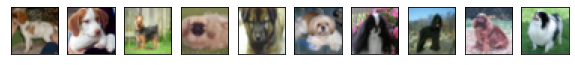


False Negatives:
[imgs to show:  10 ; total imgs found:  197 ]


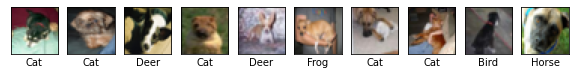


False Positives:
[imgs to show:  10 ; total imgs found:  139 ]


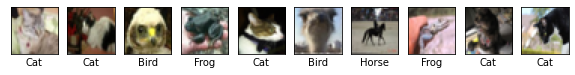

-----------------------------------------------------
.           ------Frog metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  882 ]


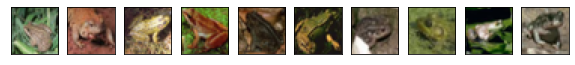


False Negatives:
[imgs to show:  10 ; total imgs found:  118 ]


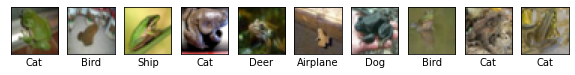


False Positives:
[imgs to show:  10 ; total imgs found:  149 ]


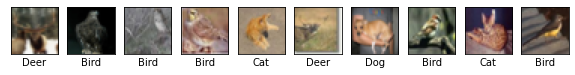

-----------------------------------------------------
.           ------Horse metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  848 ]


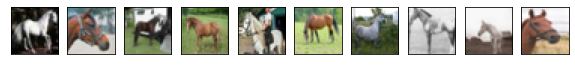


False Negatives:
[imgs to show:  10 ; total imgs found:  152 ]


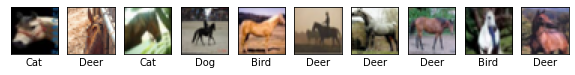


False Positives:
[imgs to show:  10 ; total imgs found:  104 ]


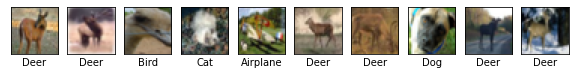

-----------------------------------------------------
.           ------Ship metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  917 ]


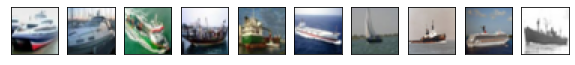


False Negatives:
[imgs to show:  10 ; total imgs found:  83 ]


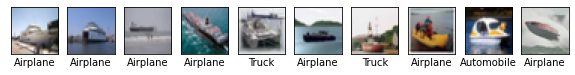


False Positives:
[imgs to show:  10 ; total imgs found:  126 ]


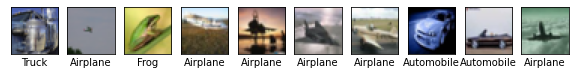

-----------------------------------------------------
.           ------Truck metrics------

Correct Predictions:
[imgs to show:  10 ; total imgs found:  900 ]


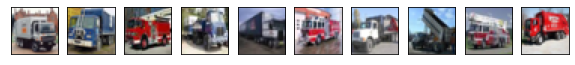


False Negatives:
[imgs to show:  10 ; total imgs found:  100 ]


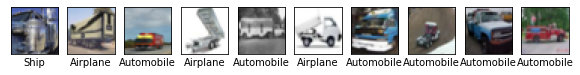


False Positives:
[imgs to show:  10 ; total imgs found:  119 ]


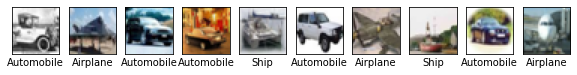

-----------------------------------------------------


In [ ]:
#
# prints out Correct Predictions, False Negative Predictions, and 
# False Positive Predictions for each name in faces.target_names
# NB that it prints out max of 10 values for each category for image
#

print()
print('-----------------------------------------------------')

for i, label in enumerate(labels):                        # one loop for each label

  print('.           ------' + label + ' metrics------')
  print()
  print('Correct Predictions:')          
  mask = (Y_true == i) & (Y_pred_classes == i)
  correct = sum(mask)                                     # total corrects
  numbers = min(10, sum(mask))
  print("[imgs to show: ", numbers, "; total imgs found: ", correct, "]")
  img_display(x_test_orig[mask], Y_pred_classes[mask], numbers, show_name = False)

  print()
  print('False Negatives:')                               # should have been positives
  mask = (Y_true == i) & (Y_pred_classes != i)
  false_negs = sum(mask)                                  # total false negatives
  numbers = min(10, sum(mask))
  print("[imgs to show: ", numbers, "; total imgs found: ", false_negs, "]")
  if numbers > 0:
    img_display(x_test_orig[mask], Y_pred_classes[mask], numbers)
  
  print()
  print('False Positives:')                               # should have been negatives
  mask = (Y_true != i) & (Y_pred_classes == i)
  false_poss = sum(mask)                                  # total false positives
  numbers = min(10, sum(mask))
  print("[imgs to show: ", numbers, "; total imgs found: ", false_poss, "]")
  if numbers > 0:
    img_display(x_test_orig[mask], y_true[mask], numbers)
      
  print('-----------------------------------------------------')

-----------------------------------

### Summary table
(manually generated)

| Method | Optimizer | Batch Size | Loss Function | Learning Rate | Epochs | Training Time | Test Accuracy | Remarks |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Baseline CNN | RMSProp | 128 | categorical crossentropy | 0.0001 | 70 | 4 min | 76.3% | Not bad for CNN model (no transfer learning), same cats and dogs misclassification problem. Good performance and model still learning after 70 epochs |
| (1) Transfer learning with ResNet50 1 | SGD | 512 | categorical_crossentropy | 0.003 | 40 | 6 min | 72.5% | Not great accuracy, cats at 54% (cats and dogs problem)
| (2A) Transfer learning with ResNet50 (adam optimizer) | adam | 512 | categorical_crossentropy | 0.003 | 40 | 6 min | 66.3% | Birds, cats and dog prediction issues (<50% acc for cats) some strange behavior on one run (drastic accuracy drops on last epoch)
| (2A.1) Transfer learning with ResNet50 (upscaling images) | RMSProp | 20 | binary_crossentropy | 2e-5 | 5 | 16 min | 91.1% | much better, clearly picking up the transfer learning model now. smaller batch size and whatever work model is doing, takes longer to train
(2B) Transfer learning with ResNet50 (dropout layer) | SGD | 512 | categorical_crossentropy | 0.003 | 40 | 6 min | 73.9% | Includes dropout layer right before final activation layer (classification layer), still not great with cats
(2C) Transfer learning with ResNet50 (learning_rate) | SGD | 512 | categorical_crossentropy | 0.01 | 40 | 6 min | 75.41% | Slightly better, SGD optimizer again, still poor at identifying cats (50%)
| (3) Transfer learning with DenseNet121 | SGD | 512 | categorical_crossentropy | ??? | 40 | 23 min | 87.6% | Much better predictive performance but long time to train, 4x longer
| (4) Transfer learning with InceptionV3 | SGD | 128 | categorical_crossentropy | 0.003 | 30 | 13 min | 85.5% | Not quite as good as DenseNet but trained for fewer epochs (Callback)

**Disclaimer:**

The results recorded in the summary table above were from our first full run through of the notebook.
When doing the final run before submission, model 2A produced a test accuracy of 74.2% but all other results are within a good range. 

### Conclusions

**Question 1: Which classes are more likely to be misclassified by this model? Does this make intuitive sense?**
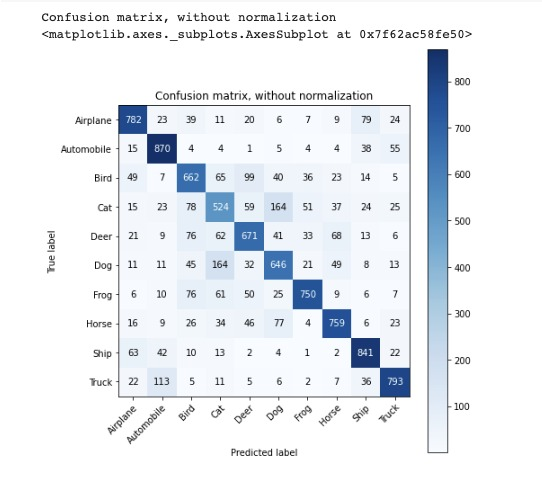

The above is the Confusion Matrix representing the Baseline ResNet implementation. We can see that it misclassifies cats and dogs and to answer the question at hand, this does make intuitive sense.


**Intro to Transfer Learning**

Transfer learning is basically reusing a previously learned model on a new problem. It is very popular in deep learning since it can train deep neural networks with a small amount of data, making it very efficient. In reality, the main benefits of transfer learning revolve around the saving of resources which ultimately reduces the time being consumed when training new models. It can also help with training models when only unlabelled datasets are available, as the bulk of the model will be pre-trained. Traditional machine learning models require training from scratch, which is computationally expensive and requires a large amount of data to achieve high performance. However, transfer learning is computationally efficient and helps achieve better results using a small data set. It also works well even when there is limited amount of labelled data. In fact, it speeds up the learning process and decreases the training time which makes the models more efficient. 

*Links supporting Transfer Learning comments*

https://www.analyticsvidhya.com/blog/2021/10/understanding-transfer-learning-for-deep-learning/

https://www.seldon.io/transfer-learning

https://www.v7labs.com/blog/transfer-learning-guide

https://www.einfochips.com/blog/how-does-transfer-learning-speeds-up-deep-learning-projects/




**Analysis of Summary Table:**

From the summary table we can see that Method 2A.1 Transfer Learning with ResNet50 (upscaling images) had the highest test accuracy, scoring 91.1%. Although this produced the best accuracy, it consists of very delicate code which is prone to errors with the smallest changes, so one should be mindful when utilizing this code. This was closely followed by the DenseNet121 model which scored 87.6%. It did take a considerably long time to train - 23 minutes being the longest training time amongst the other models. The InceptionV3 model had a test accuracy of 85.5% and a training time of 13 minutes. Both the DenseNet121 and InceptionV3 models utilized the SGD optimizer. As we can see from the summary table, once the optimizer was changed to "Adam" in Method 2A, the test accuracy had a significant drop by roughly 20%. This is quite interesting considering the fact that research suggests Adam to be the better performing optimizer compared to SGD.

The ResNet50 models had the shortest training times (apart from the 2A.1 upscaling method) and were pretty much within the 70% test accuracy range. From the 3 variations under Attempt #2, changing the optimizer had the worst impact on the overall test accuracy, dropping it down to 66.3%. On the other hand, changing the learning rate (Variation #3) had the most promising outcome with the highest test accuracy (this is excluding the 2A.1 upscaling method).

Whilst working on the assignment, we found that increasing the batch size from 128 to 512 helped the overall training time, factor of 2 or so moves things along much better.


**In-depth analysis of ResNet model**

According to research;

(https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00444-8) 

ResNet(Residual Network) was introduced after CNN (Convolutional Neural Network). In order to improve accuracy and performance, additional layers are added to a DNN which is useful in solving complex problems. It was expected that these layers would progressively learn the features however it was later found that there is a maximum threshold for depth with the traditional Convolutional Neural Network model. 

By adding more layers on top of a network, its performance ultimately degrades so the  introduction of ResNet and other residual networks have been game changing when it comes to training very deep networks.

Back in the day, deep CNN architectures were very challenging and pretty much impossible to train due to the nature of the backpropagation algorithm (https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd). ResNet added skip connections which eventually enabled better application of the backpropagation training algorithm. 

Nowadays, ResNet is used as a way to handle the vanishing gradient problem in very deep CNNs. It is an extremely intelligent network which works by skipping some layers (very interesting and useful information, especially for beginner level programmers) - this is because it assumes that very deep networks should not produce training errors. Researchers imply that it can be thought of as a model similar to LSTM.

*The following is an interesting article looking into RNN and LSTM:*

https://aditi-mittal.medium.com/understanding-rnn-and-lstm-f7cdf6dfc14e

**Addressing Question 2**

As you can see from our Transfer Learning Model 2A.1, our ResNet50 Upscaling method supports the research above. We were able to get the highest test accuracy using this particular model which implies that it is more accurate than the Baseline CNN model at hand. We actually predict that if we increase the number of epochs, we could possibly get a test accuracy of 93%+. In addition, splitting the dataset up, allowed us to get a better output which is also consistent with our other test results. Although, Model 2A.1 did take 12 more minutes to train, it is totally worth it considering a 15% increase in test accuracy. 



**Outstanding Questions post-analysis:**
1. Is the learning rate for DenseNet121 unknown on purpose? Or is there a default learning rate for this specific model?
2. Is the Adam optimizer known to perform better/worse than the SGD?
  - According to research, the Adam optimizer has shown better optimization performance than SGD. 
  - The Adam optimizer is known to perform much quicker than SGD as it implicitly performs coordinate-wise gradient clipping and can tackle heavy-tailed noise. 
  - Research also suggests that fine-tuned Adam is always better than SGD when using default parameters
  - So why are we getting better results using SGD?
